# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_2m_1f_240216_3"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [80, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 77456
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,796.732992,8.441112,796.422344,8.466959,0.0,817.000000,0.0000,0.627451,756.000000,0.0000,-1.541108,1367.0,100.027659,23.368144,0.972329,4
1,1,0,1675.074365,622.916476,1674.851835,609.354531,0.0,1676.000000,481.0000,0.403922,1691.000000,510.0000,-0.048906,9171.0,278.728381,75.031878,0.963086,4
2,2,0,1516.384105,674.327283,1512.332606,672.654154,0.0,1447.000000,584.0000,0.541176,1516.000000,680.0000,0.606200,12671.0,223.520752,94.321118,0.906605,4
3,3,0,1632.564717,899.106800,1628.763157,901.233196,NaN,1632.564717,899.1068,NaN,1632.564717,899.1068,-0.358625,9897.0,232.909858,64.294838,0.961143,4
4,0,3,796.773527,8.285386,796.441044,8.311851,0.0,756.000000,4.0000,0.627451,756.000000,0.0000,-1.544484,1307.0,98.181577,23.556442,0.970791,4
5,1,3,1674.892351,658.652900,1675.555104,655.716524,0.0,1711.000000,545.0000,0.349020,1674.000000,585.0000,-0.173461,6707.0,163.212718,74.175756,0.890761,4


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         4   796.732992    8.441112    -1.541108
1   1     0         4  1675.074365  622.916476    -0.048906
2   2     0         4  1516.384105  674.327283     0.606200
3   3     0         4  1632.564717  899.106800    -0.358625


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1675.074365,622.916476,1674.851835,609.354531,0.0,1676.000000,481.000000,0.403922,1691.000000,510.000000,0.048906,9171.0,278.728381,75.031878,0.963086,4
2,1,0,1516.384105,674.327283,1512.332606,672.654154,0.0,1447.000000,584.000000,0.541176,1516.000000,680.000000,0.606200,12671.0,223.520752,94.321118,0.906605,4
3,2,0,1632.564717,899.106800,1628.763157,901.233196,NaN,1632.564717,899.106800,NaN,1632.564717,899.106800,0.358625,9897.0,232.909858,64.294838,0.961143,4
4,0,3,796.773527,8.285386,796.441044,8.311851,0.0,756.000000,4.000000,0.627451,756.000000,0.000000,-1.544484,1307.0,98.181577,23.556442,0.970791,4
5,1,3,1674.892351,658.652900,1675.555104,655.716524,0.0,1711.000000,545.000000,0.349020,1674.000000,585.000000,-0.173461,6707.0,163.212718,74.175756,0.890761,4
6,2,3,1516.454846,674.307614,1512.574885,672.624489,0.0,1447.000000,584.000000,0.501961,1489.000000,705.000000,0.601934,12701.0,223.422362,94.254236,0.906658,4
7,3,3,1632.598094,899.371895,1628.712608,901.786328,NaN,1632.598094,899.371895,NaN,1632.598094,899.371895,-0.361070,9863.0,232.219921,64.241982,0.960973,4


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
49715,3,29994,1613.666146,227.419537,1608.980363,224.088914,0.0,1572.000000,153.00000,0.403922,1542.000000,173.00000,0.955648,10247.0,213.871545,80.707232,0.926065,4
49716,0,29997,1594.047134,27.824682,1592.098690,28.494597,0.0,1538.000000,0.00000,0.325490,1644.000000,12.00000,-1.356891,6280.0,156.650992,57.901810,0.929182,4
49717,1,29997,958.572793,135.390320,956.813568,136.324679,NaN,958.572793,135.39032,NaN,958.572793,135.39032,-1.517421,15290.0,259.260885,86.607515,0.942553,4
49718,2,29997,1436.351119,283.863937,1432.039240,287.068712,0.0,1458.000000,149.00000,0.486275,1436.000000,186.00000,-0.220725,11039.0,240.720547,73.560025,0.952166,4
49719,3,29997,1613.462056,227.370562,1608.719801,224.074582,0.0,1572.000000,153.00000,0.403922,1525.000000,173.00000,0.957549,10252.0,214.333648,80.695427,0.926419,4


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


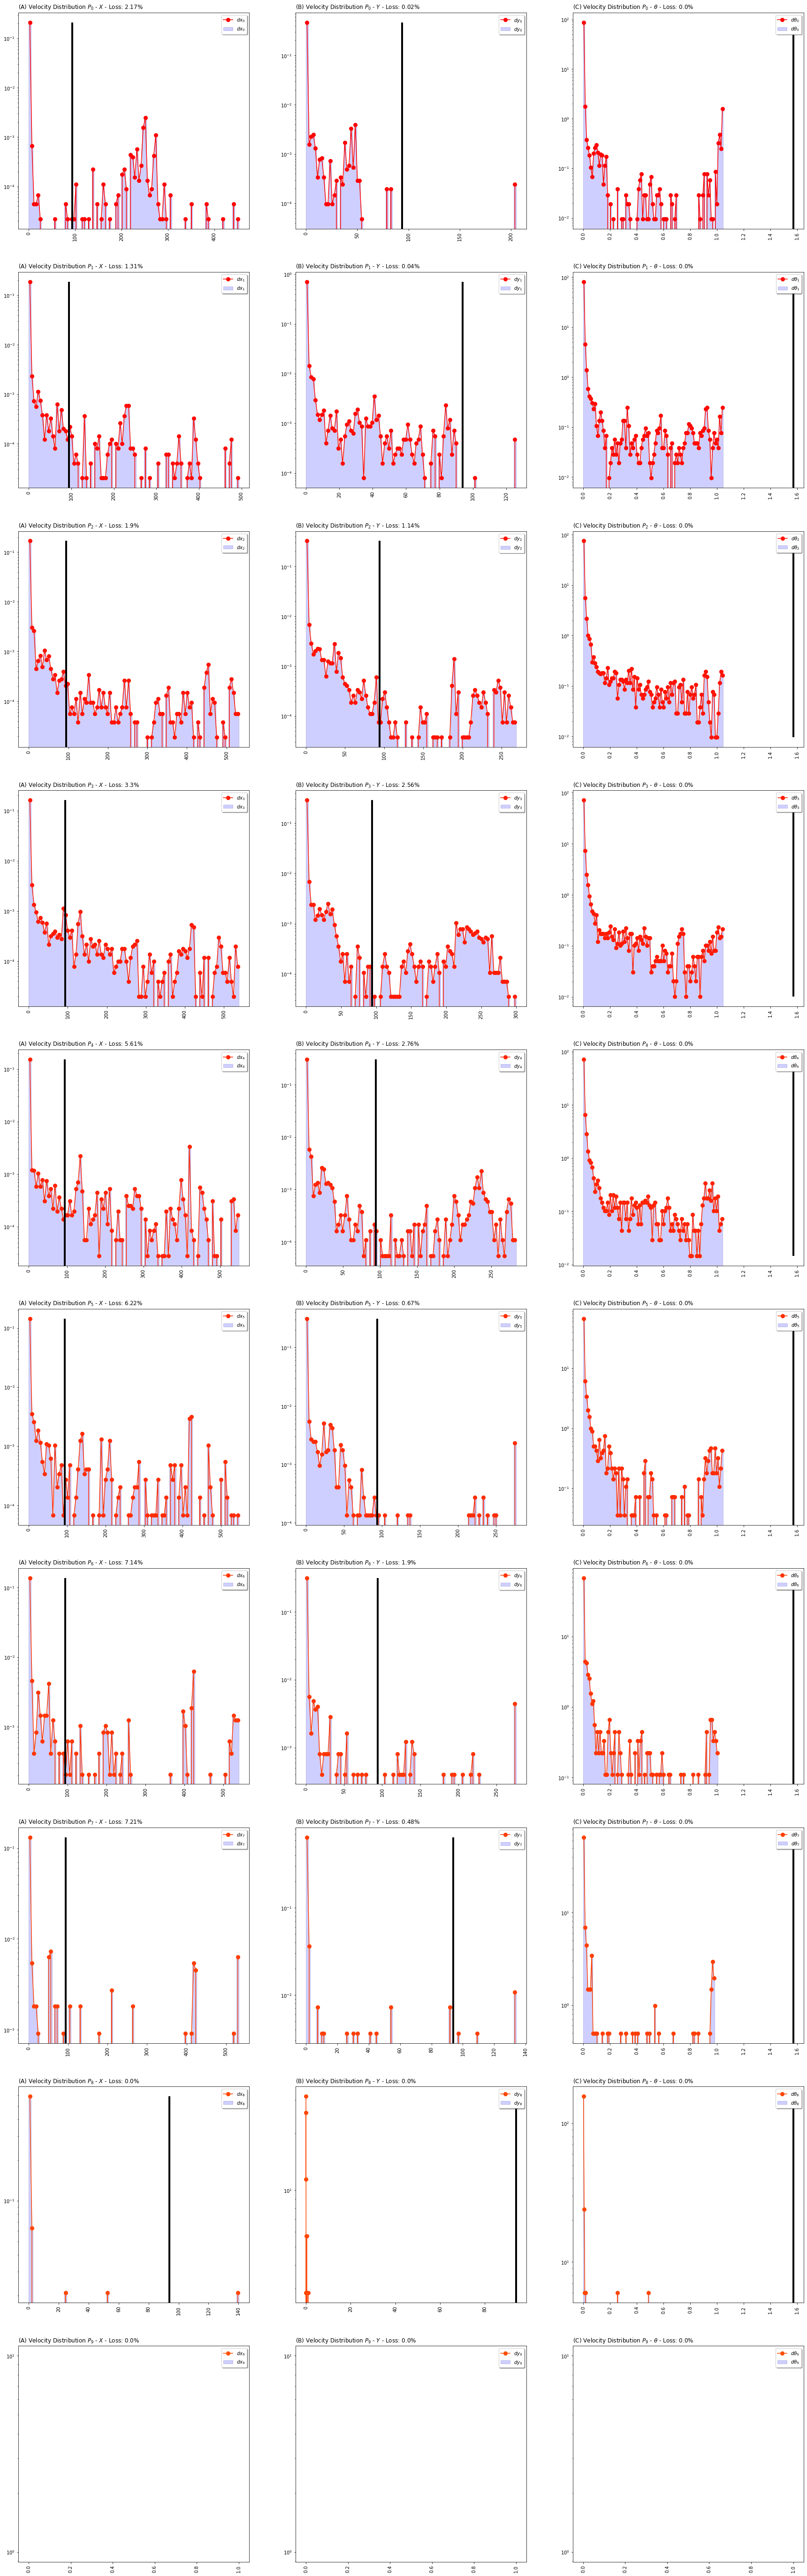

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,3,1836
1,4,11451
2,5,19290
3,6,10626
4,7,4816
5,8,1384
6,9,306
7,10,10


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 35.44997660341117 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,3.425250
1,3,False,True,False,0.086486
2,3,True,False,False,0.164927
3,3,True,True,False,0.016090
4,4,False,False,False,22.007683
5,4,False,True,False,0.370080
6,4,True,False,False,0.607414
7,4,True,True,False,0.046260
8,5,False,False,False,37.563105
9,5,False,True,False,0.319797


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 0.9318362099743938 
	- Angle: 35.44997660341117 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 7.02%
Final loss data Y-axis: 7.346666666666666%
Final loss data Angle : 0.7233333333333334%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.350000
1,3,False,False,True,4.010000
2,3,False,True,False,0.100000
3,3,False,True,True,2.560000
4,3,True,False,False,0.020000
5,3,True,False,True,2.966667
6,3,True,True,False,0.253333
7,3,True,True,True,89.740000


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 0.9318362099743938 
	- Angle: 35.44997660341117 



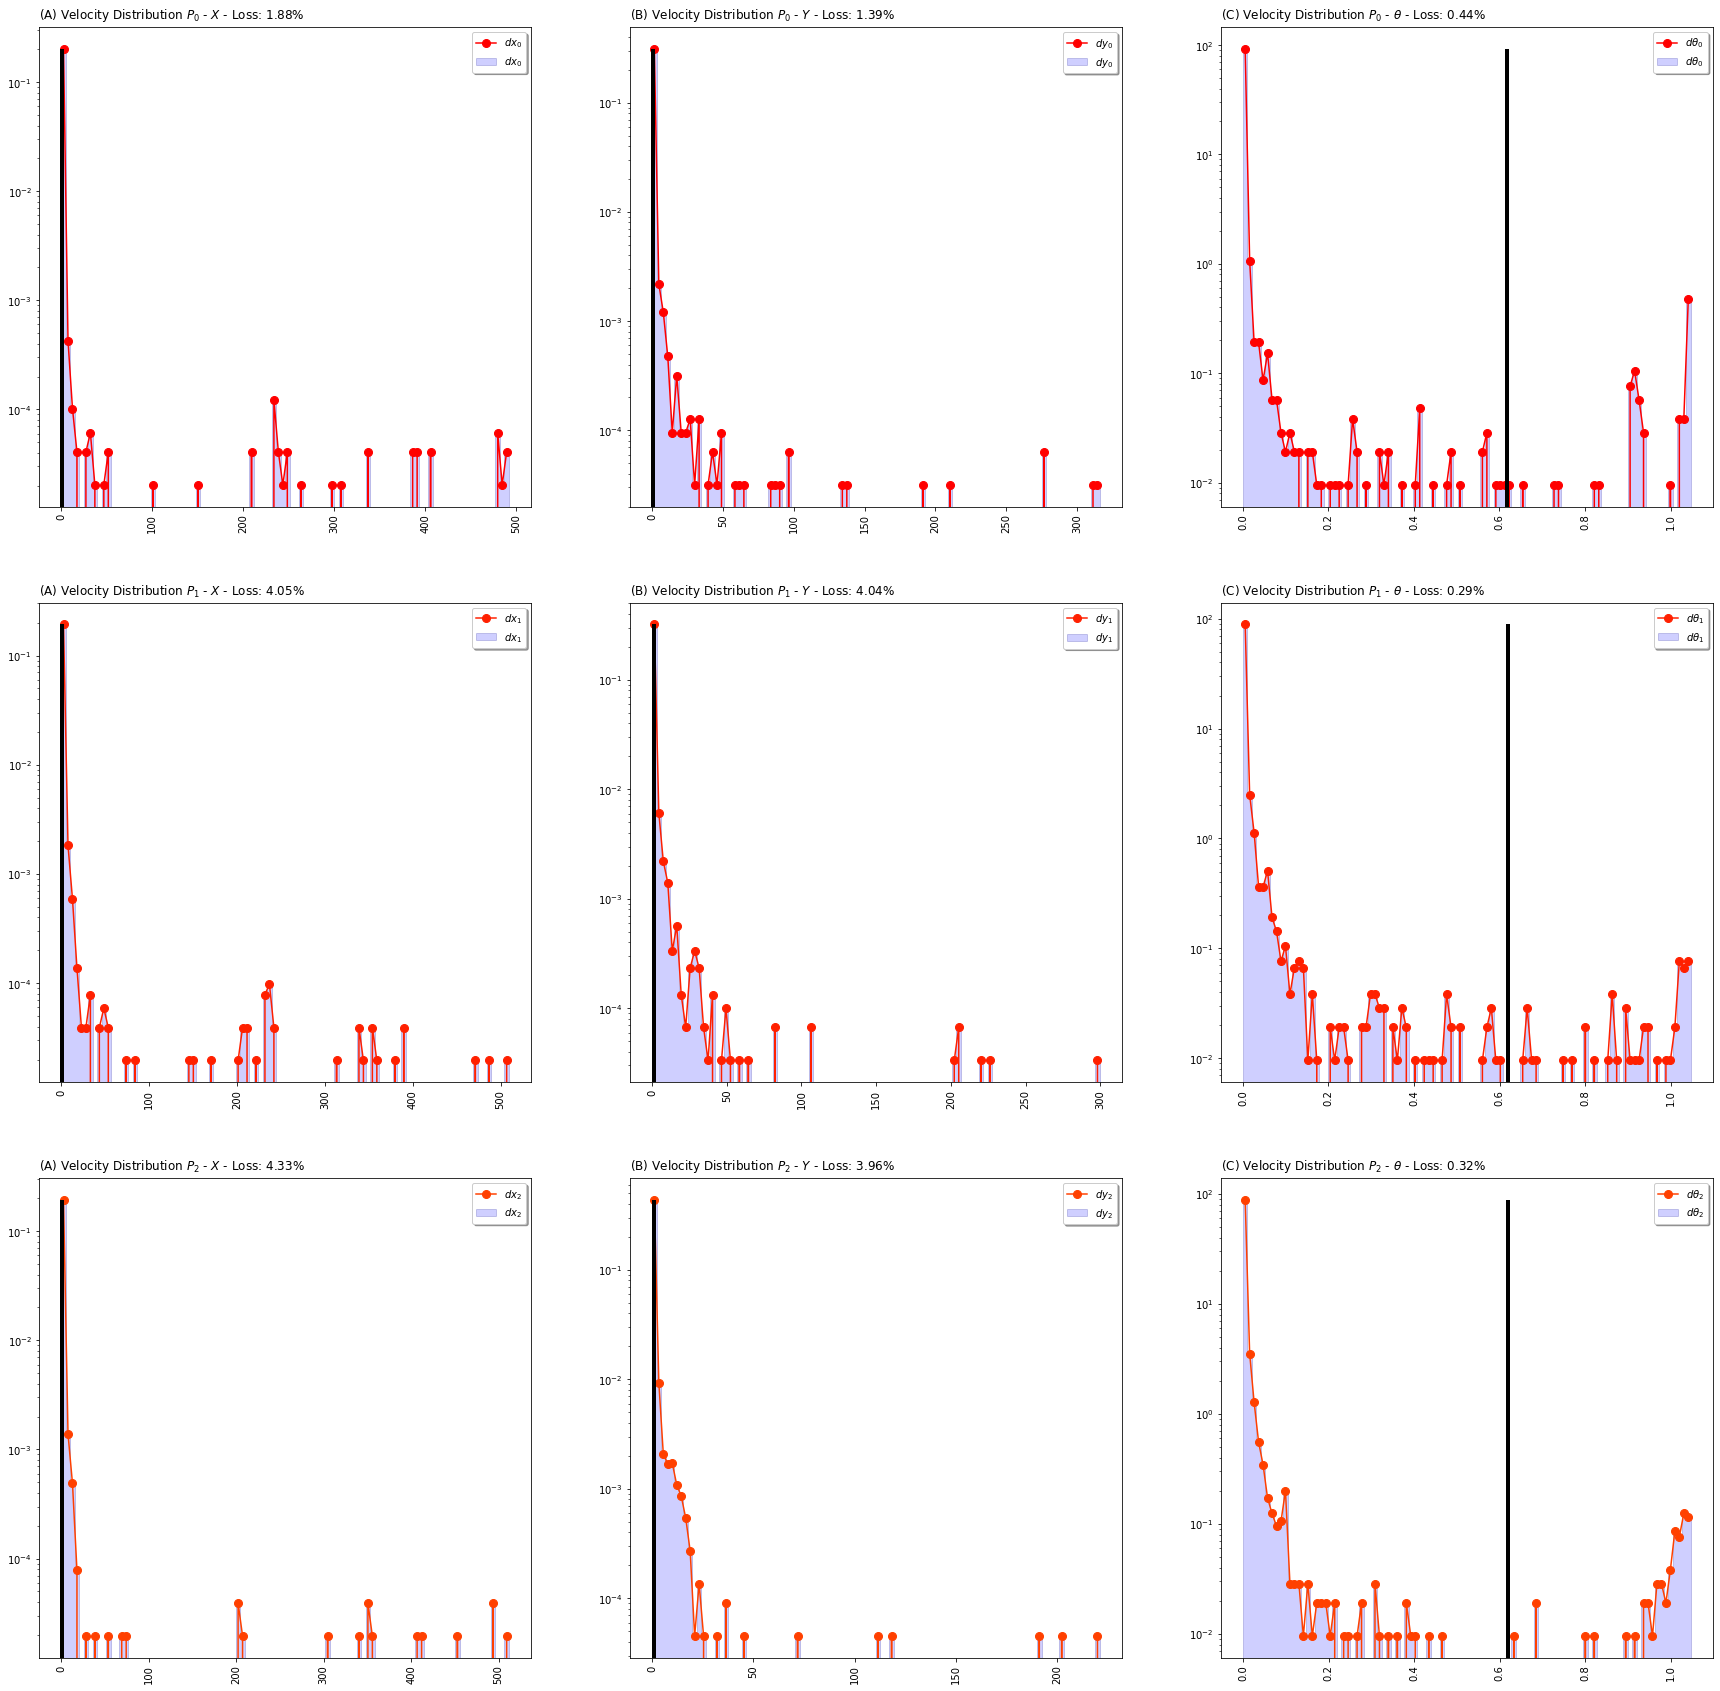

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1675.074365,622.916476,1674.851835,609.354531,0.0,1676.000000,481.000000,0.403922,1691.000000,510.000000,0.048906,9171.0,278.728381,75.031878,0.963086,3,NaN,NaN,NaN,NaN,False,False,False
613,1,0,1516.384105,674.327283,1512.332606,672.654154,0.0,1447.000000,584.000000,0.541176,1516.000000,680.000000,0.606200,12671.0,223.520752,94.321118,0.906605,3,NaN,NaN,NaN,NaN,False,False,False
1226,2,0,1632.564717,899.106800,1628.763157,901.233196,NaN,1632.564717,899.106800,NaN,1632.564717,899.106800,0.358625,9897.0,232.909858,64.294838,0.961143,3,NaN,NaN,NaN,NaN,False,False,False
1839,0,3,1674.983358,640.784688,1675.203470,632.535527,0.0,1693.500000,513.000000,0.403922,1682.500000,547.500000,0.048906,9171.0,278.728381,75.031878,0.963086,3,3.0,-0.030336,5.956071,0.0,False,True,False
1840,1,3,1516.384105,674.327283,1512.332606,672.654154,0.0,1447.000000,584.000000,0.541176,1516.000000,680.000000,0.606200,12671.0,223.520752,94.321118,0.906605,3,3.0,0.000000,0.000000,0.0,False,False,False
1841,2,3,1632.581405,899.239348,1628.737882,901.509762,NaN,1632.581405,899.239348,NaN,1632.581405,899.239348,0.358625,9897.0,232.909858,64.294838,0.961143,3,3.0,0.005563,0.044182,0.0,False,False,False
1842,0,6,1674.934525,649.744778,1675.399577,644.142232,0.0,1702.250000,529.000000,0.403922,1677.250000,566.250000,0.048906,9171.0,278.728381,75.031878,0.963086,3,3.0,-0.016278,2.986697,0.0,False,True,False
1843,1,6,1516.384105,674.327283,1512.332606,672.654154,0.0,1447.000000,584.000000,0.541176,1516.000000,680.000000,0.606200,12671.0,223.520752,94.321118,0.906605,3,3.0,0.000000,0.000000,0.0,False,False,False
1844,2,6,1632.599477,899.353908,1628.701669,901.745656,NaN,1632.599477,899.353908,NaN,1632.599477,899.353908,0.358625,9897.0,232.909858,64.294838,0.961143,3,3.0,0.006024,0.038187,0.0,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_2m_1f_240216_3_c.zip'